In [102]:
using StaticArrays, SeeToDee
using ControlSystemIdentification, ControlSystemsBase
using ControlSystemsBase.DemoSystems: resonant
using LowLevelParticleFilters
using LeastSquaresOptim
using Random, Plots, LinearAlgebra
using Plots


In [103]:
function AsvLin(v, input, p, t)
    m1, m2, m3 = p[1], p[2], p[3]
    Xu, Yv, Yr, Nv, Nr = p[4], p[5], p[6], p[7], p[8]
    Xuu, Yvv, Nrr = p[9], p[10], p[11]
    Xuuu, Yvvv, Nrrr = p[12], p[13], p[14]
    
    u, v, r = v[1], v[2], v[3]
    X, Y, N = input[1], input[2], input[3]

    v1 = (1/m1) * (Xu*u + X)
    v2 = (1/m2) * (Yv*v + Yr*r + Y)
    v3 = (1/m3) * (Nv*v + Nr*r + N)
    
    return SA[v1, v2, v3]
end

function AsvSwayYaw(v, input, p, t)
    m1, m2, m3 = p[1], p[2], p[3]
    Xu, Yv, Yr, Nv, Nr = p[4], p[5], p[6], p[7], p[8]
    Xuu, Yvv, Nrr = p[9], p[10], p[11]
    Xuuu, Yvvv, Nrrr = p[12], p[13], p[14]
    
    u, v, r = v[1], v[2], v[3]
    X, Y, N = input[1], input[2], input[3]

    v1 = (1/m1) * (Xu*u + Xuu*abs(u)*u + Xuuu*u^3 + X)
    v2 = (1/m2) * (Yv*v + Yr*r + Yvv*abs(v)*v + Yvvv*v^3 + Y)
    v3 = (1/m3) * (Nv*v + Nr*r + Nrr*abs(r)*r + Nrrr*r^3 + N)
    return SA[v1, v2, v3]
end

function AsvNoCross(v, input, p, t)
    m1, m2, m3 = p[1], p[2], p[3]
    Xu, Yv, Yr, Nv, Nr = p[4], p[5], p[6], p[7], p[8]
    Xuu, Yvv, Nrr = p[9], p[10], p[11]
    Xuuu, Yvvv, Nrrr = p[12], p[13], p[14]
    
    u, v, r = v[1], v[2], v[3]
    X, Y, N = input[1], input[2], input[3]

    v1 = (1/m1) * (Xu*u + Xuu*abs(u)*u + Xuuu*u^3 + X)
    v2 = (1/m2) * (Yv*v + Yvv*abs(v)*v + Yvvv*v^3 + Y)
    v3 = (1/m3) * (Nr*r + Nrr*abs(r)*r + Nrrr*r^3 + N)
    return SA[v1, v2, v3]
end


measurement(v, u, p, t) = SA[v[1], v[2], v[3]]
Ts = 0.02
discrete_dynamics_lin = SeeToDee.Rk4(AsvLin, Ts, supersample=2)
discrete_dynamics_sway_yaw = SeeToDee.Rk4(AsvSwayYaw, Ts, supersample=2)
discrete_dynamics_no_cross = SeeToDee.Rk4(AsvNoCross, Ts, supersample=2)

SeeToDee.Rk4{typeof(AsvNoCross), Float64}(AsvNoCross, 0.02, 2)

In [104]:
df = CSV.File("validation_data.csv", header=false) |> DataFrame
t = df[:, 1]
# position and orientation
x = df[:, 2]
y = df[:, 3]
psi = df[:, 4]

# velocities (states)
u = df[:, 5]
v = df[:, 6]
r = df[:, 7]

# forces and moments (inputs)
Fx = df[:, 8]
Fy = df[:, 9]
Nz = df[:, 10]

nx = 3
ny = 3
nu = 3

3

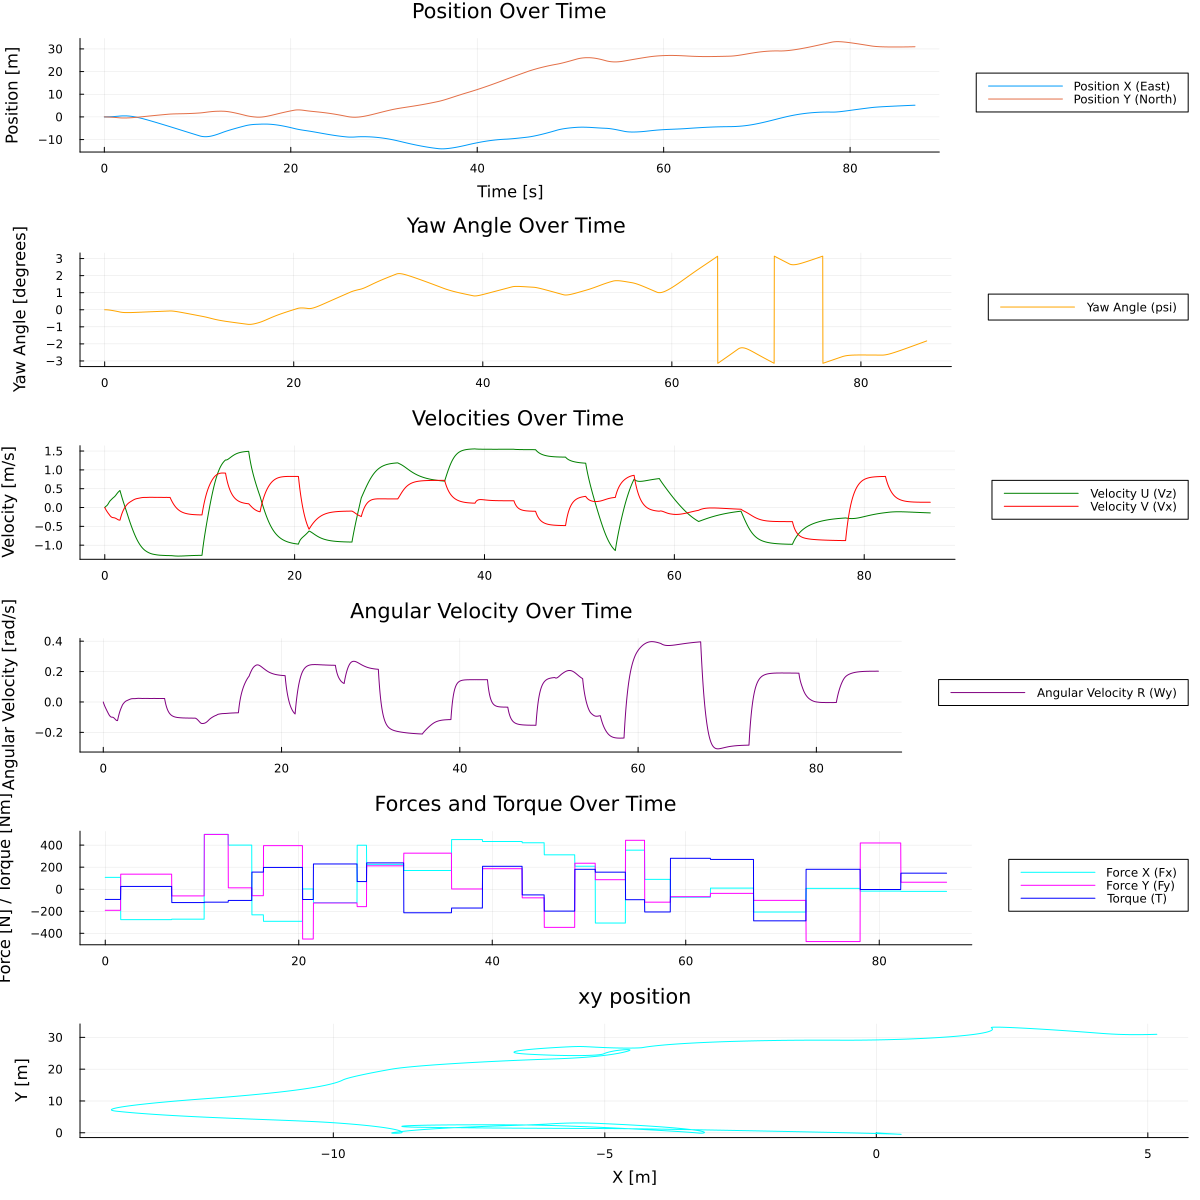

In [105]:

# Set a larger size for each plot and use a grid layout to give more space
layout = @layout([a; b; c; d; e; f])
plt = plot(layout = layout, size = (1200, 1200))

# Define global x and y labels for all plots
x_label = "Time [s]"
y_labels = ["Position [m]", "Yaw Angle [degrees]", "Velocity [m/s]", "Angular Velocity [rad/s]", "Force [N] / Torque [Nm]", "Y [m]"]
titles = ["Position Over Time", "Yaw Angle Over Time", "Velocities Over Time", "Angular Velocity Over Time", "Forces and Torque Over Time", "xy position"]

for (i, y_label) in enumerate(y_labels)
    xlabel!(plt[i], x_label)
    ylabel!(plt[i], y_label)
    title!(plt[i], titles[i])
end

# Adjust legends to be outside the plot area
legend_position = :outerright

# Plot the data
plot!(plt[1], t, x, label="Position X (East)", legend=legend_position)
plot!(plt[1], t, y, label="Position Y (North)", legend=legend_position)

plot!(plt[2], t, psi, label="Yaw Angle (psi)", color=:orange, legend=legend_position)

plot!(plt[3], t, u, label="Velocity U (Vz)", color=:green, legend=legend_position)
plot!(plt[3], t, v, label="Velocity V (Vx)", color=:red, legend=legend_position)

plot!(plt[4], t, r, label="Angular Velocity R (Wy)", color=:purple, legend=legend_position)

plot!(plt[5], t, Fx, label="Force X (Fx)", color=:cyan, legend=legend_position)
plot!(plt[5], t, Fy, label="Force Y (Fy)", color=:magenta, legend=legend_position)
plot!(plt[5], t, Nz, label="Torque (T)", color=:blue, legend=legend_position)

# For the xy position, if yflip is necessary, uncomment it
plot!(plt[6], x, y, label="position", color=:cyan, legend=false)
# plot!(plt[6], yflip=true)

# Remove xlabel and ylabel for plots except the first in each column
xlabel!(plt[1], "Time [s]")
xlabel!(plt[6], "X [m]")
for i in 2:5
    xlabel!(plt[i], "")
end

display(plt)


In [106]:


# Create input and output matrices
U = vcat.(Fx, Fy, Nz)

x0 = [0.0, 0.0, 0.0] 
p_fit_lin = [432.35632367841094, 375.66973655617244, 618.7306767242195, -242.601040977979, -525.4586690226001, -61.99002993943749, -5.896994722547811, -1001.6781172305579, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = LowLevelParticleFilters.rollout(discrete_dynamics_lin, x0, U, p_fit_lin)[1:end-1]

U = reduce(hcat, U)
Y = reduce(hcat, Y)

3×4349 Matrix{Float64}:
 0.0   0.00494132   0.00982749  …  -0.0798305  -0.079845  -0.0798592
 0.0  -0.0100339   -0.0197816       0.105199    0.105169   0.105139
 0.0  -0.00294951  -0.00580318      0.144379    0.144382   0.144385

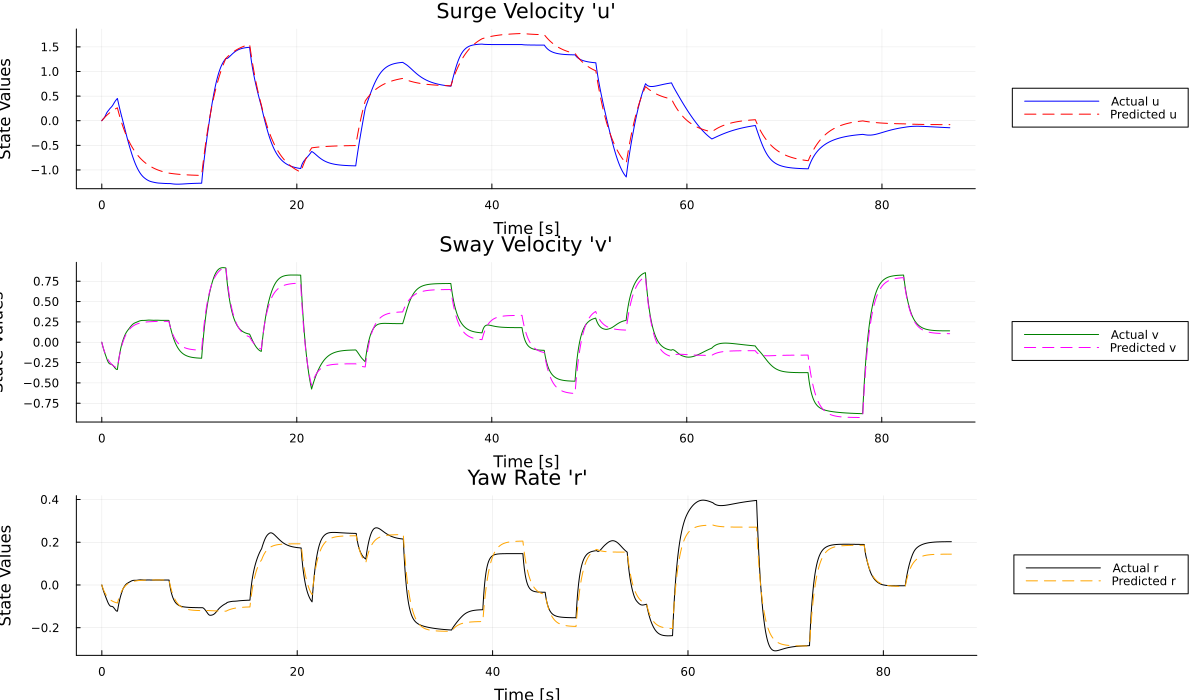

In [107]:
p1 = plot(t, u, label="Actual u", color=:blue, title="Surge Velocity 'u'")
plot!(p1, t, Y[1, :], label="Predicted u", color=:red, linestyle=:dash)

p2 = plot(t, v, label="Actual v", color=:green, title="Sway Velocity 'v'")
plot!(p2, t, Y[2, :], label="Predicted v", color=:magenta, linestyle=:dash)

p3 = plot(t, r, label="Actual r", color=:black, title="Yaw Rate 'r'")
plot!(p3, t, Y[3, :], label="Predicted r", color=:orange, linestyle=:dash)

final_plot = plot(p1, p2, p3, layout = (3, 1), legend=:outerright, size = (1200, 700))

xlabel!(final_plot, "Time [s]")
ylabel!(final_plot, "State Values")
display(final_plot)
